In [1]:
## All code for Omar Armbruster 704 Paper

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import math
import random
from scipy import constants
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras
import bz2
import pickle
from VAE import VAE

import os
os.environ["OMP_NUM_THREADS"] = '1'

In [95]:
N = 100000
Tc = (N * 2) ** (1 / 3) / (2 * 1.202) ** (1 / 3) # Critical Temperature
lp = 1
noise = 0.1
tempRange = "0.5to2"
# in_file = bz2.BZ2File(f"../../../../../../Desktop/generated_data/full_generated_data_BIMODAL_TF_AND_BE_noise_0.1_{tempRange}.bz2",'rb')
# vals = (list(pickle.load(in_file)))
# newVals = [np.array(val) for val in vals]
# data = newVals[0]
# temps = newVals[1][:,0]
# test_data = newVals[2]
# test_temps = newVals[3][:,0]
# in_file.close()
temps = np.loadtxt('../../../Tensorflow/704Data/704Temps.txt', delimiter=',')
data = np.loadtxt('../../../Tensorflow/704Data/704Data.txt', delimiter=',')
test_temps = np.loadtxt('../../../Tensorflow/704Data/704TestTemps.txt', delimiter=',')
test_data = np.loadtxt('../../../Tensorflow/704Data/704TestData.txt', delimiter=',')
size = len(temps)
y = int(len(data[0])**0.5)
testSize = len(test_temps)
testY = int(len(test_data[0])**0.5)

data = data.reshape(size, y, y)
test_data = test_data.reshape(testSize, testY, testY)

In [96]:
def calculateConductances(fitImgs, clusters, matrix):
    conductance0 = []
    conductance1 = []
    for v in range(len(fitImgs)):
        vol = np.sum(matrix[v])
        cutWeights0 = 0
        cutWeights1 = 0
        for w in range(len(fitImgs)):
            if clusters[w] == 0:
                cutWeights0 += matrix[v,w]
            elif clusters[w] == 1:
                cutWeights1 += matrix[v,w]
        conductanceScore0 = cutWeights0/vol if vol > 0 else 1
        conductanceScore1 = cutWeights1/vol if vol > 0 else 1
        conductance0.append(conductanceScore0)
        conductance1.append(conductanceScore1)
    return conductance0, conductance1

def binTemps(bin_num, temps, conductance0, conductance1, Tc):
    bins = np.linspace(0.5, 2, bin_num)
    print(max(temps/Tc))
    tempbins = np.digitize(temps/Tc, bins)
    binVals0 = {}
    binVals1 = {}
    for i in range(len(tempbins)):
        if bins[tempbins[i]] in list(binVals0.keys()):
            binVals0[bins[tempbins[i]]].append(conductance0[i])
            binVals1[bins[tempbins[i]]].append(conductance1[i])
        else:
            binVals0[bins[tempbins[i]]] = [conductance0[i]]
            binVals1[bins[tempbins[i]]] = [conductance1[i]]
    for key in binVals0.keys():
        m = np.mean(binVals0[key])
        std = np.std(binVals0[key])
        binVals0[key] = [m, std]
    for key in binVals1.keys():
        m = np.mean(binVals1[key])
        std = np.std(binVals1[key])
        binVals1[key] = [m, std]
    return np.array(list(binVals0.keys())), np.array(list(binVals0.values())), np.array(list(binVals1.keys())), np.array(list(binVals1.values()))

def getGroups(fitImgs, clusters, temps, Tc):
    group1 = fitImgs[clusters == 0]
    group2 = fitImgs[clusters == 1]
    labels = np.array(len(temps)*['blue'])
    labels[temps >= Tc] = 'red'
    labels1 = labels[clusters == 0]
    labels2 = labels[clusters == 1]
    return group1, group2, labels1, labels2
legend_elements = [
    plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'w', markeredgecolor = 'blue', label = 'Below Tc'),
    plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'w', markeredgecolor = 'red', label = 'Equal to or Above Tc'),
    plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'green', label = 'First Cluster'),
    plt.Line2D([0], [0], marker = 'o', color = 'w',markerfacecolor = 'orange', label = 'Second Cluster'),
]

def calculateAccuracy(clusters, temps, Tc):
    if type(Tc) == float:
        Tc = len(temps)*[Tc]
    acc = np.zeros(len(temps))
    for i in range(len(acc)):
        if ((temps[i] < Tc[i] and clusters[i] == 0) or (temps[i] >= Tc[i] and clusters[i] == 1)):
            acc[i] = 1
    return acc if np.sum(acc)/len(temps) > 0.5 else abs(acc - 1)

def correctCluster(cluster, temps, Tc):
    idx = np.where(temps/Tc == np.max(temps/Tc))[0][0]
    if cluster[idx] == 0:
        return abs(cluster - 1)
    return cluster

Text(0.5, 1.0, '1.85Tc')

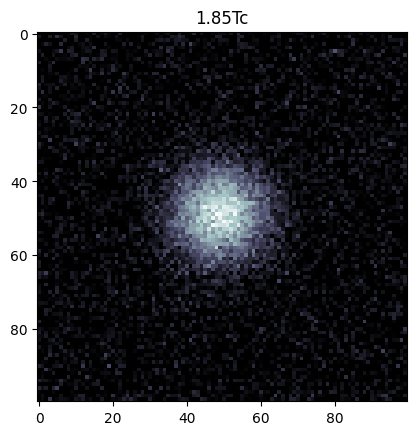

In [4]:
idx = 1
plt.imshow(data[idx], cmap = 'bone')
plt.title(f'{round(temps[idx]/Tc, 2)}Tc')

# Data Processing

## PCA

In [97]:
## Fit Data
flatImgs = np.array(data).reshape(len(data), y*y)
scaledImgs = StandardScaler().fit_transform(flatImgs)
pca = PCA(n_components = 2)
fitImgsPCA = pca.fit_transform(scaledImgs)

In [6]:
rbfCoefPCA = 5e-3
neighborsPCA = int(0.1*len(data))

## Cluster Data
spectralClusterNPCA = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors', n_neighbors = neighborsPCA, n_init=200) # Cluster with neighbors
spectralClusterRPCA = SpectralClustering(n_clusters = 2, affinity = 'rbf', gamma = rbfCoefPCA, n_init = 200) # Use affinity matrix for continuous distances
spectralNPCA = correctCluster(spectralClusterNPCA.fit_predict(fitImgsPCA), temps, Tc)
spectralRPCA = correctCluster(spectralClusterRPCA.fit_predict(fitImgsPCA), temps, Tc)

## Accuracy
accuracyNPCA = calculateAccuracy(spectralNPCA, temps, Tc)
accuracyRPCA = calculateAccuracy(spectralRPCA, temps, Tc)

## Calculate Conductance for Nearest Neighbors (N) and Radial Basis Function (R)
conductanceNPCA0, conductanceNPCA1 = calculateConductances(fitImgsPCA, spectralNPCA, spectralClusterNPCA.affinity_matrix_)
conductanceRPCA0, conductanceRPCA1 = calculateConductances(fitImgsPCA, spectralRPCA, spectralClusterRPCA.affinity_matrix_)

## VAE

Epoch: 50, Test set ELBO: -1864.83056640625, time elapse for current epoch: 0.8059322834014893


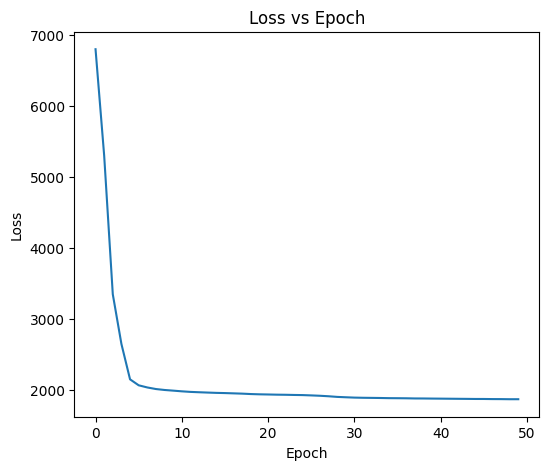

In [7]:
## Fit Data
vae = VAE(data, test_data, batch_size = 32, epochs = 50)
fitImgsVAE = vae.encode(data)
vae.plot_loss()

In [8]:
rbfCoefVAE = 1e-1
neighborsVAE = int(0.1*len(data))

## Cluster Data
spectralClusterNVAE = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors', n_neighbors = neighborsVAE, n_init = 200) # Cluster with neighbors
spectralClusterRVAE = SpectralClustering(n_clusters = 2, affinity = 'rbf', gamma = rbfCoefVAE, n_init = 200) # Use affinity matrix for continuous distances
spectralNVAE = correctCluster(spectralClusterNVAE.fit_predict(fitImgsVAE), temps, Tc)
spectralRVAE = correctCluster(spectralClusterRVAE.fit_predict(fitImgsVAE), temps, Tc)

## Accuracy
accuracyNVAE = calculateAccuracy(spectralNVAE, temps, Tc)
accuracyRVAE = calculateAccuracy(spectralRVAE, temps, Tc)

## Calculate Conductance
conductanceNVAE0, conductanceNVAE1 = calculateConductances(fitImgsVAE, spectralNVAE, spectralClusterNVAE.affinity_matrix_)
conductanceRVAE0, conductanceRVAE1 = calculateConductances(fitImgsVAE, spectralRVAE, spectralClusterRVAE.affinity_matrix_)

# Dimensionally Reduced Plots

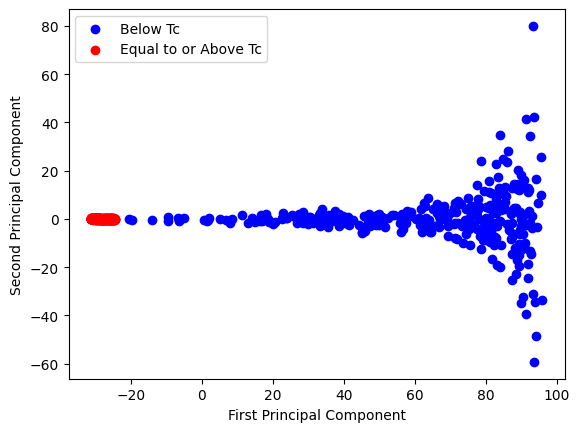

In [9]:
fig = plt.figure()
# plt.scatter(fitImgsPCA[:,0], fitImgsPCA[:,1], color = 'black')
# plt.title("PCA Dimensional Reduction")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
# Optional 
group1 = fitImgsPCA[temps < Tc]
group2 = fitImgsPCA[temps >= Tc]
plt.scatter(group1[:,0], group1[:,1], label = 'Below Tc', color = 'blue')
plt.scatter(group2[:,0], group2[:,1], label = 'Equal to or Above Tc', color = 'red')
plt.legend()

In [11]:
fig.savefig('704Figures/PCA Dimensional Reduction.png', bbox_inches = 'tight')

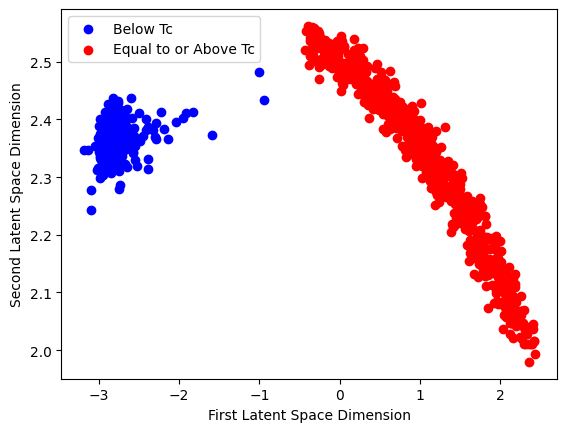

In [12]:
fig = plt.figure()
# plt.scatter(fitImgsVAE[:,0], fitImgsVAE[:,1], color = 'black')
# plt.title("VAE Dimensional Reduction")
plt.xlabel('First Latent Space Dimension')
plt.ylabel('Second Latent Space Dimension')
# Optional 
group1 = fitImgsVAE[temps < Tc]
group2 = fitImgsVAE[temps >= Tc]
plt.scatter(group1[:,0], group1[:,1], label = 'Below Tc', color = 'blue')
plt.scatter(group2[:,0], group2[:,1], label = 'Equal to or Above Tc', color = 'red')
plt.legend()


In [13]:
fig.savefig('704Figures/VAE Dimensional Reduction.png', bbox_inches = 'tight')

# Clustering

## Nearest Neighbors

Text(0, 0.5, 'Second Principal Component')

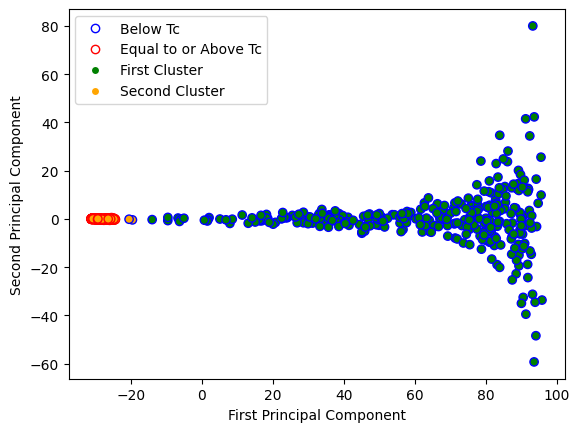

In [14]:
fig = plt.figure()
group1, group2, labels1, labels2 = getGroups(fitImgsPCA, spectralNPCA, temps, Tc)
plt.scatter(group1[:,0], group1[:,1], color = 'green', label = 'First Cluster', edgecolors = labels1)
plt.scatter(group2[:,0], group2[:,1], color = 'orange', label = 'Second Cluster', edgecolors = labels2)
plt.legend(handles = legend_elements)
# plt.title("PCA with Nearest Neighbors Clustering")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [15]:
fig.savefig('704Figures/PCA with Nearest Neighbors Clustering.png', bbox_inches = 'tight')

1.99940562105972


([<matplotlib.axis.XTick at 0x7fd9321b2cd0>,
 [Text(0.5, 0, '$T_c/2$'),
  Text(1.0, 0, '$T_c$'),
  Text(1.5, 0, '$3T_c/2$'),
  Text(2.0, 0, '$2T_c$')])

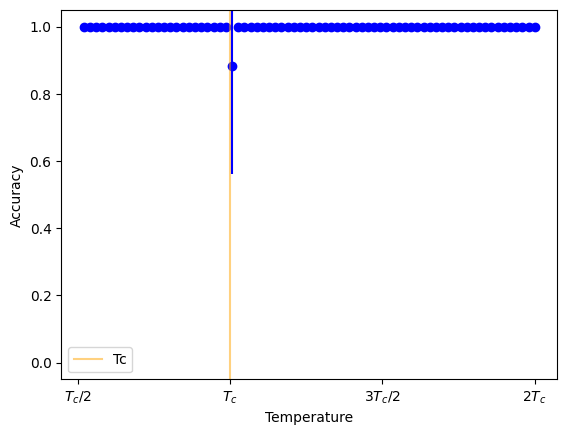

In [16]:
fig = plt.figure()
bins0, vals0, _,_ = binTemps(75, temps, accuracyNPCA, accuracyNPCA, Tc)
plt.axvline(1, color = 'orange', label = 'Tc', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)

In [17]:
fig.savefig('704Figures/PCA NN Accuracy.png', bbox_inches = 'tight')

Text(0, 0.5, 'Second Latent Space Dimension')

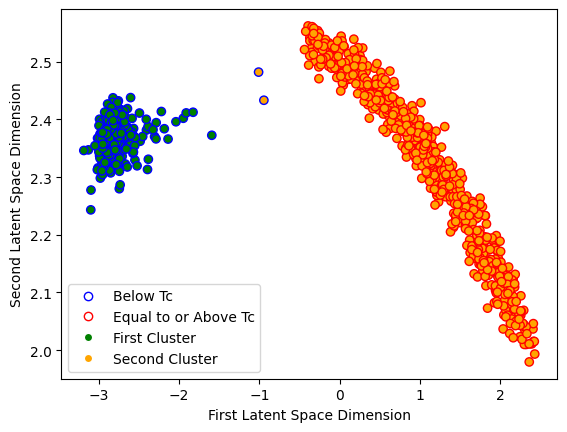

In [18]:
fig = plt.figure()
group1, group2, labels1, labels2 = getGroups(fitImgsVAE, spectralNVAE, temps, Tc)
plt.scatter(group1[:,0], group1[:,1], color = 'green', label = 'First Cluster', edgecolor = labels1)
plt.scatter(group2[:,0], group2[:,1], color = 'orange', label = 'Second Cluster', edgecolor = labels2)
plt.legend(handles = legend_elements)
# plt.title("VAE with Nearest Neighbors Clustering")
plt.xlabel('First Latent Space Dimension')
plt.ylabel('Second Latent Space Dimension')

In [19]:
fig.savefig('704Figures/VAE with Nearest Neighbors Clustering.png', bbox_inches = 'tight')

1.99940562105972


([<matplotlib.axis.XTick at 0x7fd89863e310>,
 [Text(0.5, 0, '$T_c/2$'),
  Text(1.0, 0, '$T_c$'),
  Text(1.5, 0, '$3T_c/2$'),
  Text(2.0, 0, '$2T_c$')])

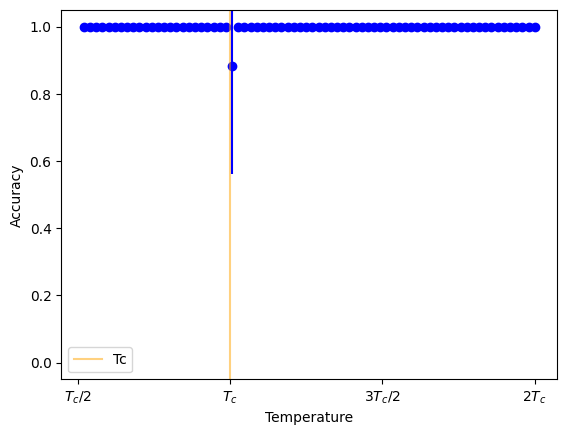

In [20]:
fig = plt.figure()
bins0, vals0, _,_ = binTemps(75, temps, accuracyNVAE, accuracyNVAE, Tc)
plt.axvline(1, color = 'orange', label = 'Tc', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)

In [21]:
fig.savefig('704Figures/VAE NN Accuracy.png', bbox_inches = 'tight')

## RBF

Text(0, 0.5, 'Second Principal Component')

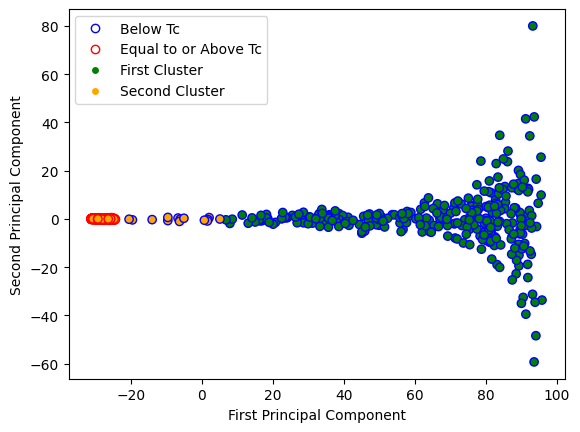

In [22]:
fig = plt.figure()
# group1 = fitImgsPCA[spectralRPCA == 0]
# group2 = fitImgsPCA[spectralRPCA == 1]
group1, group2, labels1, labels2 = getGroups(fitImgsPCA, spectralRPCA, temps, Tc)
plt.scatter(group1[:,0], group1[:,1], color = 'green', label = 'First Cluster', edgecolor = labels1)
plt.scatter(group2[:,0], group2[:,1], color = 'orange', label = 'Second Cluster', edgecolor = labels2)
plt.legend(handles = legend_elements)
# plt.title("PCA with Radial Basis Function Clustering")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [23]:
fig.savefig('704Figures/PCA with Radial Basis Function Clustering.png', bbox_inches = 'tight')

1.99940562105972


([<matplotlib.axis.XTick at 0x7fd898568b20>,
 [Text(0.5, 0, '$T_c/2$'),
  Text(1.0, 0, '$T_c$'),
  Text(1.5, 0, '$3T_c/2$'),
  Text(2.0, 0, '$2T_c$')])

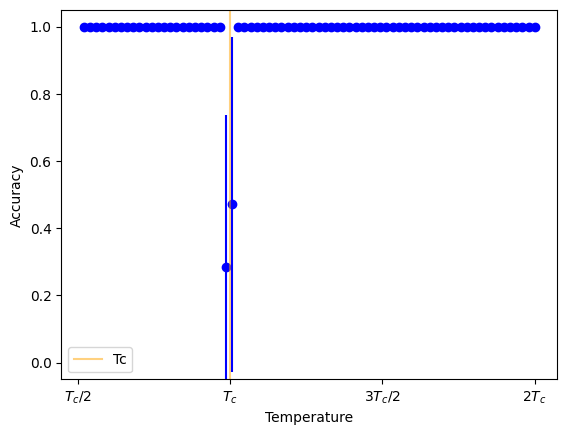

In [24]:
fig = plt.figure()
bins0, vals0, _,_ = binTemps(75, temps, accuracyRPCA, accuracyRPCA, Tc)
plt.axvline(1, color = 'orange', label = 'Tc', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)

In [25]:
fig.savefig('704Figures/PCA RBF Accuracy.png', bbox_inches = 'tight')

Text(0, 0.5, 'Second Latent Space Dimension')

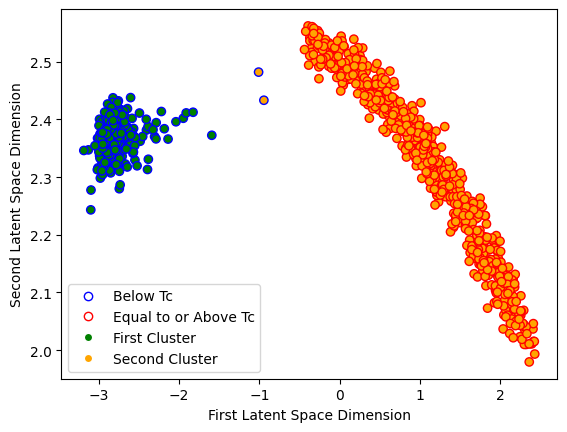

In [26]:
fig = plt.figure()
# group1 = fitImgsVAE[spectralRVAE == 0]
# group2 = fitImgsVAE[spectralRVAE == 1]
group1, group2, labels1, labels2 = getGroups(fitImgsVAE, spectralRVAE, temps, Tc)
plt.scatter(group1[:,0], group1[:,1], color = 'green', label = 'First Cluster', edgecolor = labels1)
plt.scatter(group2[:,0], group2[:,1], color = 'orange', label = 'Second Cluster', edgecolor = labels2)
plt.legend(handles = legend_elements)
# plt.title("VAE with Radial Basis Function Clustering")
plt.xlabel('First Latent Space Dimension')
plt.ylabel('Second Latent Space Dimension')

In [27]:
fig.savefig('704Figures/VAE with Radial Basis Function Clustering.png', bbox_inches = 'tight')

1.99940562105972


([<matplotlib.axis.XTick at 0x7fd89841b040>,
 [Text(0.5, 0, '$T_c/2$'),
  Text(1.0, 0, '$T_c$'),
  Text(1.5, 0, '$3T_c/2$'),
  Text(2.0, 0, '$2T_c$')])

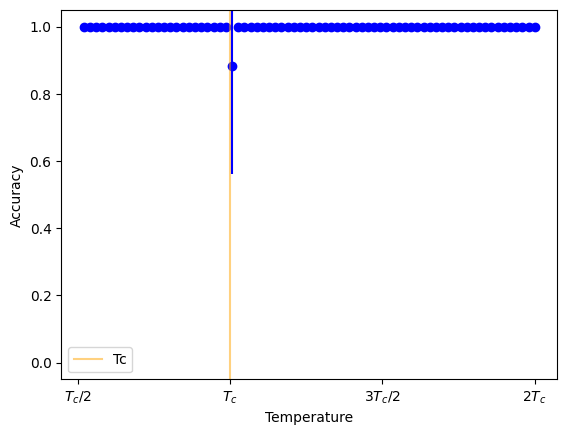

In [28]:
fig = plt.figure()
bins0, vals0, _,_ = binTemps(75, temps, accuracyRVAE, accuracyRVAE, Tc)
plt.axvline(1, color = 'orange', label = 'Tc', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)

In [29]:
fig.savefig('704Figures/VAE RBF Accuracy.png', bbox_inches = 'tight')

# Conductance

## Neighbors

1.99940562105972


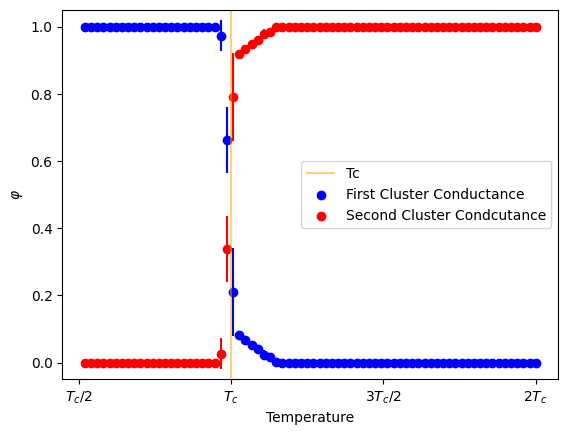

In [37]:
bins0, vals0, bins1, vals1 = binTemps(75, temps, conductanceNPCA0, conductanceNPCA1, Tc)
fig = plt.figure()
plt.axvline(1, label = 'Tc', color = 'orange', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue', label = 'First Cluster Conductance')
plt.scatter(bins1, vals1[:,0], color = 'red', label = 'Second Cluster Condcutance')
plt.errorbar(bins0, vals0[:,0], yerr = vals0[:,1], fmt = 'none', color = 'blue')
plt.errorbar(bins1, vals1[:,0], yerr = vals1[:,1],fmt = 'none', color = 'red')
plt.xlabel('Temperature')
plt.ylabel('$\\varphi$')
plt.ylim(-0.05, 1.05)
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)
plt.legend()
# plt.title('PCA Conductance with Nearest Neighbors Clustering')

In [38]:
fig.savefig('704Figures/PCA Conductance with Nearest Neighbors Clustering.png', bbox_inches = 'tight')

1.99940562105972


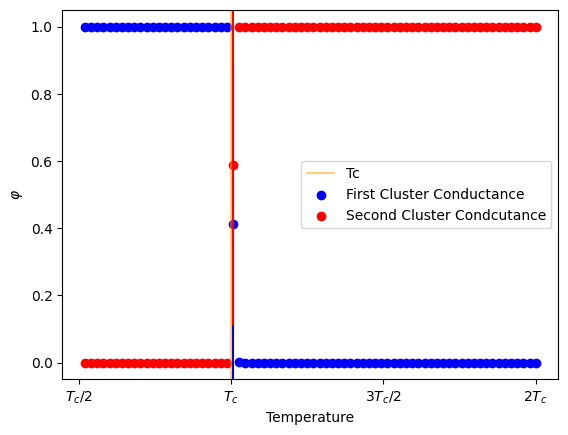

In [40]:
bins0, vals0, bins1, vals1 = binTemps(75, temps, conductanceNVAE0, conductanceNVAE1, Tc)
fig = plt.figure()
plt.axvline(1, label = 'Tc', color = 'orange', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue', label = 'First Cluster Conductance')
plt.scatter(bins1, vals1[:,0], color = 'red', label = 'Second Cluster Condcutance')
plt.errorbar(bins0, vals0[:,0], color = 'blue', fmt='none', yerr=vals0[:,1])
plt.errorbar(bins1, vals1[:,0], color = 'red', fmt='none', yerr=vals1[:,1])
plt.xlabel('Temperature')
plt.ylabel('$\\varphi$')
plt.ylim(-0.05, 1.05)
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)
plt.legend()
# plt.title('VAE Conductance with Nearest Neighbors Clustering')

In [41]:
fig.savefig('704Figures/VAE Conductance with Nearest Neighbors Clustering.png', bbox_inches = 'tight')

## RBF

1.99940562105972


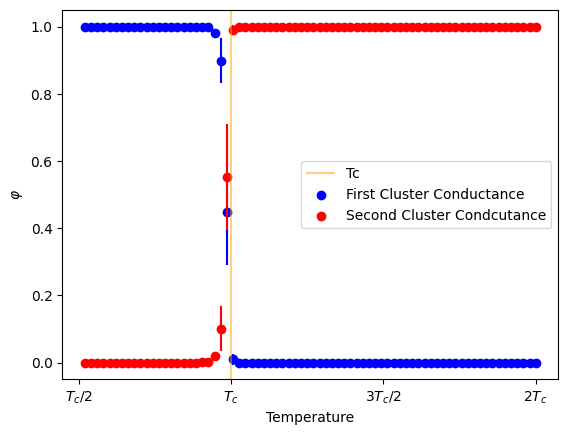

In [42]:
bins0, vals0, bins1, vals1 = binTemps(75, temps, conductanceRPCA0, conductanceRPCA1, Tc)
fig = plt.figure()
plt.axvline(1, label = 'Tc', color = 'orange', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue', label = 'First Cluster Conductance')
plt.scatter(bins1, vals1[:,0], color = 'red', label = 'Second Cluster Condcutance')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.errorbar(bins1, vals1[:,0], color = 'red', yerr = vals1[:,1], fmt = 'none')
plt.xlabel('Temperature')
plt.ylabel('$\\varphi$')
plt.ylim(-0.05, 1.05)
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)
plt.legend()
# plt.title('PCA Conductance with Radial Basis Function Clustering')

In [43]:
fig.savefig('704Figures/PCA Conductance with Radial Basis Function Clustering.png', bbox_inches = 'tight')

1.99940562105972


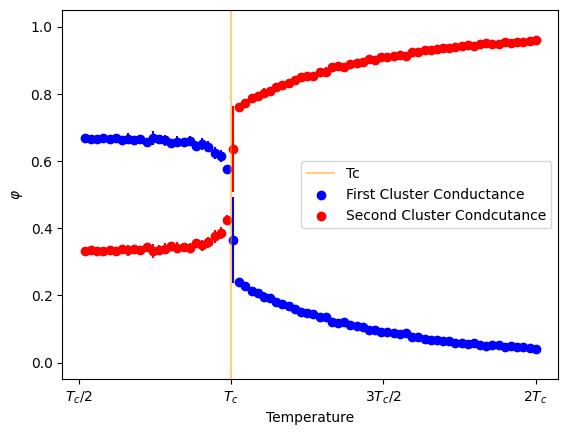

In [44]:
bins0, vals0, bins1, vals1 = binTemps(75, temps, conductanceRVAE0, conductanceRVAE1, Tc)
fig = plt.figure()
plt.axvline(1, label = 'Tc', color = 'orange', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue', label = 'First Cluster Conductance')
plt.scatter(bins1, vals1[:,0], color = 'red', label = 'Second Cluster Condcutance')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.errorbar(bins1, vals1[:,0], color = 'red', yerr = vals1[:,1], fmt = 'none')
plt.xlabel('Temperature')
plt.ylabel('$\\varphi$')
plt.ylim(-0.05, 1.05)
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)
plt.legend()
# plt.title('VAE Conductance with Radial Basis Function Clustering')

In [45]:
fig.savefig('704Figures/VAE Conductance with Radial Basis Function Clustering.png', bbox_inches = 'tight')

# Reconstructions

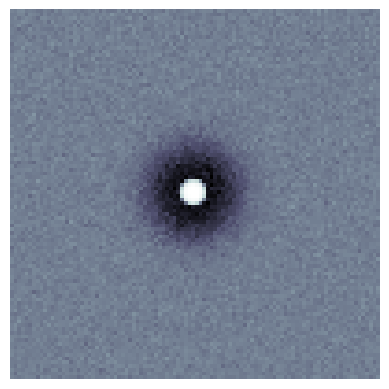

In [98]:
reconstruct = pca.components_
component1 = reconstruct[0].reshape(y,y)
component2 = reconstruct[1].reshape(y,y)
plt.imshow(component1, cmap = 'bone')
plt.axis('off')
plt.savefig('704Figures/PCAReconstruction1.png', bbox_inches = 'tight')
# plt.title('First Principal Component')


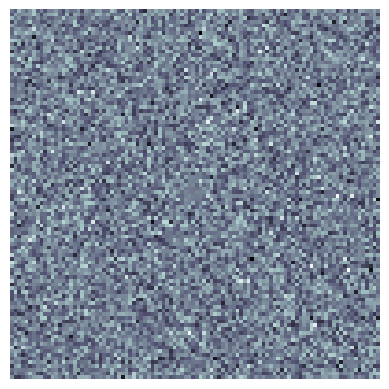

In [100]:
plt.imshow(component2, cmap = 'bone')
plt.axis('off')
plt.savefig('704Figures/PCAReconstruction2.png', bbox_inches = 'tight')
# plt.title('Second Principal Component')

[-2.7761579, 2.3696373] [1.1172636, 2.309021]


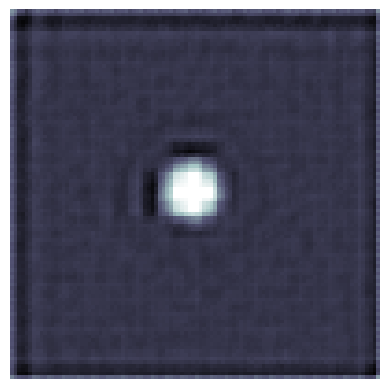

In [48]:
group1 = fitImgsVAE[temps < Tc]
group2 = fitImgsVAE[temps >= Tc]
lowTempLatent = [np.mean(group1[:,0]),np.mean(group1[:,1])]
highTempLatent = [np.mean(group2[:,0]),np.mean(group2[:,1])]
print(lowTempLatent, highTempLatent)
latent = vae.decode(tf.convert_to_tensor([lowTempLatent,highTempLatent]))
plt.imshow(latent[0], cmap = 'bone')
plt.axis('off')
plt.savefig('704Figures/VAEReconstruction1.png', bbox_inches = 'tight')
# plt.title('First Cluster Decoding')

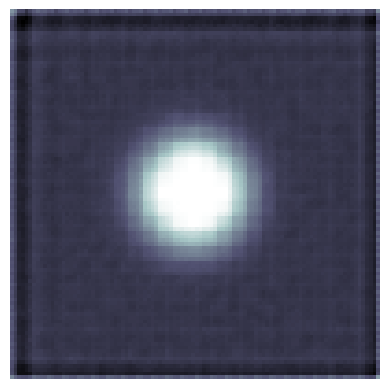

In [49]:
plt.imshow(latent[1], cmap = 'bone')
plt.axis('off')
plt.savefig('704Figures/VAEReconstruction2.png', bbox_inches = 'tight')
# plt.title('Second Cluster Decoding')

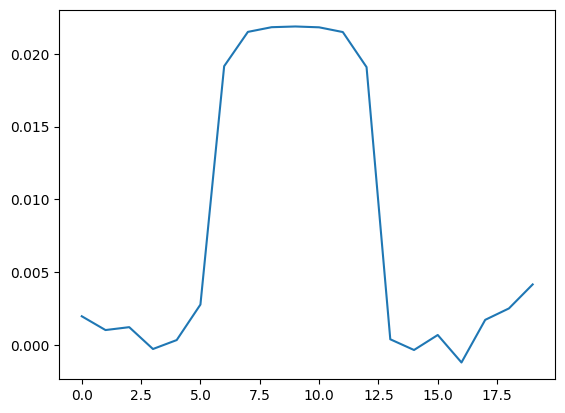

In [50]:
plt.plot(component1[49, 40:60])

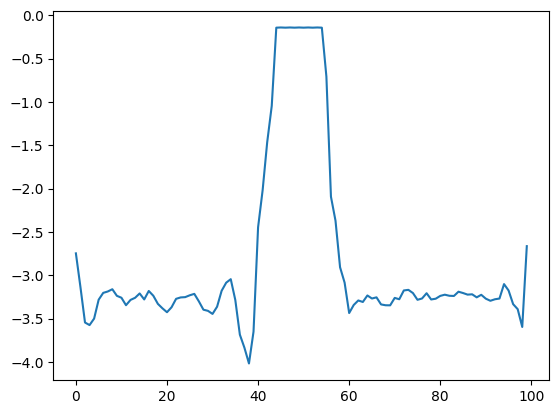

In [51]:
plt.plot(latent[0][49, :])

# Varying N 

In [52]:
lp = 1
noise = 0.1
tempRange = "0.5to2"
temps, Tcs, Ns = np.loadtxt('../../../Tensorflow/704Data/704TempsMixedN.txt', delimiter=',')
data = np.loadtxt('../../../Tensorflow/704Data/704DataMixedN.txt', delimiter=',')
test_temps, test_Tcs, test_Ns = np.loadtxt('../../../Tensorflow/704Data/704TestTempsMixedN.txt', delimiter=',')
test_data = np.loadtxt('../../../Tensorflow/704Data/704TestDataMixedN.txt', delimiter=',')
size = len(temps)
y = int(len(data[0])**0.5)
testSize = len(test_temps)
testY = int(len(test_data[0])**0.5)

data = data.reshape(size, y, y)
test_data = test_data.reshape(testSize, testY, testY)

## PCA

In [53]:
## Fit Data
flatImgs = np.array(data).reshape(len(data), y*y)
scaledImgs = StandardScaler().fit_transform(flatImgs)
pca = PCA(n_components = 2)
fitImgsPCA = pca.fit_transform(scaledImgs)

In [54]:
rbfCoefPCA = 5e-3
neighborsPCA = int(0.15*len(data))

## Cluster Data
spectralClusterNPCA = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors', n_neighbors = neighborsPCA, n_init = 200, assign_labels = 'discretize') # Cluster with neighbors
spectralClusterRPCA = SpectralClustering(n_clusters = 2, affinity = 'rbf', gamma = rbfCoefPCA, n_init = 200, assign_labels = 'discretize') # Use affinity matrix for continuous distances
spectralNPCA = correctCluster(spectralClusterNPCA.fit_predict(fitImgsPCA), temps, Tcs)
spectralRPCA = correctCluster(spectralClusterRPCA.fit_predict(fitImgsPCA), temps, Tcs)

## Accuracy
accuracyNVAE = calculateAccuracy(spectralNPCA, temps, Tcs)
accuracyRVAE = calculateAccuracy(spectralRPCA, temps, Tcs)

## Calculate Conductance for Nearest Neighbors (N) and Radial Basis Function (R)
conductanceNPCA0, conductanceNPCA1 = calculateConductances(fitImgsPCA, spectralNPCA, spectralClusterNPCA.affinity_matrix_)
conductanceRPCA0, conductanceRPCA1 = calculateConductances(fitImgsPCA, spectralRPCA, spectralClusterRPCA.affinity_matrix_)

## VAE

Epoch: 50, Test set ELBO: -1885.6455078125, time elapse for current epoch: 0.8066766262054443


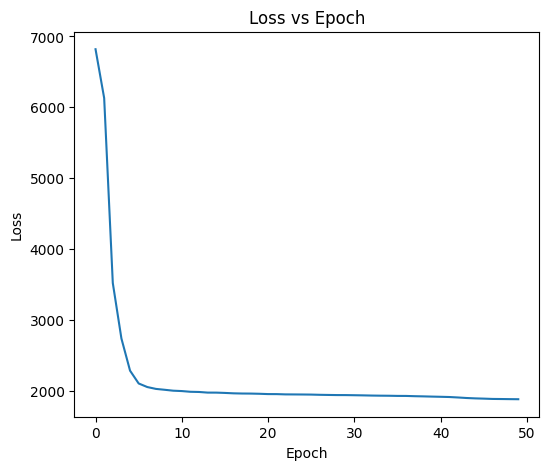

In [55]:
## Fit Data
vae = VAE(data, test_data, batch_size = 32, epochs = 50)
fitImgsVAE = vae.encode(data)
vae.plot_loss()

In [56]:
rbfCoefVAE = 1e-1
neighborsVAE = int(0.15*len(data))

## Cluster Data
spectralClusterNVAE = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors', n_neighbors = neighborsVAE, n_init = 200) # Cluster with neighbors
spectralClusterRVAE = SpectralClustering(n_clusters = 2, affinity = 'rbf', gamma = rbfCoefVAE, n_init = 200) # Use affinity matrix for continuous distances
spectralNVAE = correctCluster(spectralClusterNVAE.fit_predict(fitImgsVAE), temps, Tcs)
spectralRVAE = correctCluster(spectralClusterRVAE.fit_predict(fitImgsVAE), temps, Tcs)

## Accuracy
accuracyNVAE = calculateAccuracy(spectralNVAE, temps, Tcs)
accuracyRVAE = calculateAccuracy(spectralRVAE, temps, Tcs)

## Calculate Conductance
conductanceNVAE0, conductanceNVAE1 = calculateConductances(fitImgsVAE, spectralNVAE, spectralClusterNVAE.affinity_matrix_)
conductanceRVAE0, conductanceRVAE1 = calculateConductances(fitImgsVAE, spectralRVAE, spectralClusterRVAE.affinity_matrix_)

# Dimensionally Reduced Plots

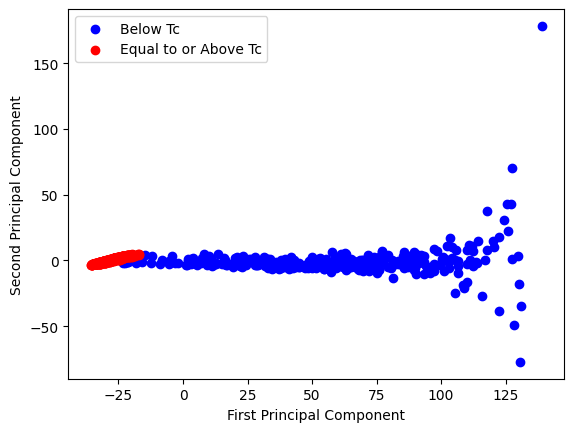

In [57]:
fig = plt.figure()
# plt.scatter(fitImgsPCA[:,0], fitImgsPCA[:,1], color = 'black')
# plt.title("PCA Dimensional Reduction")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
# Optional 
group1 = fitImgsPCA[temps < Tcs]
group2 = fitImgsPCA[temps >= Tcs]
plt.scatter(group1[:,0], group1[:,1], label = 'Below Tc', color = 'blue')
plt.scatter(group2[:,0], group2[:,1], label = 'Equal to or Above Tc', color = 'red')
plt.legend()

In [58]:
fig.savefig('704Figures/PCA VaryingN DimRed.png', bbox_inches = 'tight')

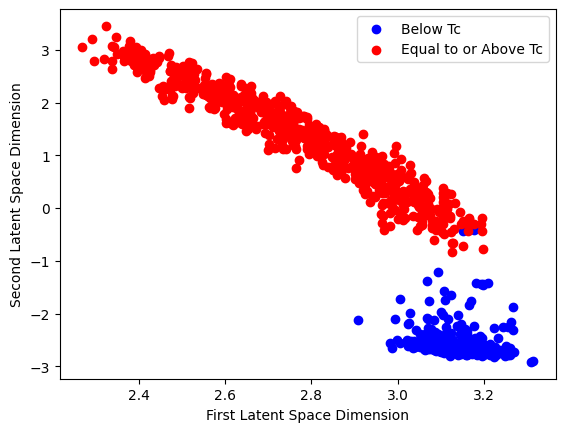

In [59]:
fig = plt.figure()
# plt.scatter(fitImgsVAE[:,0], fitImgsVAE[:,1], color = 'black')
# plt.title("VAE Dimensional Reduction")
plt.xlabel('First Latent Space Dimension')
plt.ylabel('Second Latent Space Dimension')
# Optional 
group1 = fitImgsVAE[temps < Tcs]
group2 = fitImgsVAE[temps >= Tcs]
plt.scatter(group1[:,0], group1[:,1], label = 'Below Tc', color = 'blue')
plt.scatter(group2[:,0], group2[:,1], label = 'Equal to or Above Tc', color = 'red')
plt.legend()


In [60]:
fig.savefig('704Figures/VAE VaryingN DimRed.png', bbox_inches = 'tight')

# Clustering

## Nearest Neighbors

Text(0, 0.5, 'Second Principal Component')

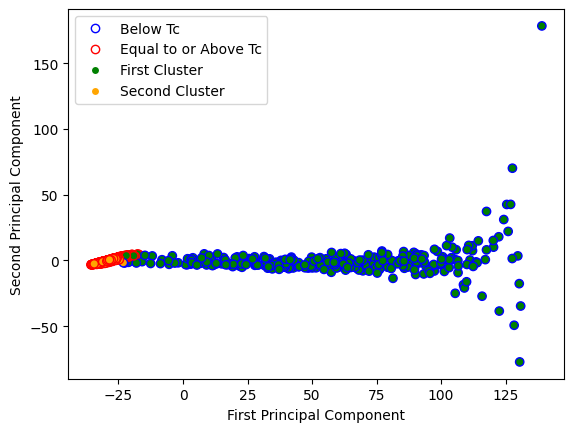

In [61]:
fig = plt.figure()
group1, group2, labels1, labels2 = getGroups(fitImgsPCA, spectralNPCA, temps, Tcs)
plt.scatter(group1[:,0], group1[:,1], color = 'green', label = 'First Cluster', edgecolors = labels1)
plt.scatter(group2[:,0], group2[:,1], color = 'orange', label = 'Second Cluster', edgecolors = labels2)
plt.legend(handles = legend_elements)
# plt.title("PCA with Nearest Neighbors Clustering")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [62]:
fig.savefig('704Figures/PCA VaryingN NN Cluster.png', bbox_inches = 'tight')

1.9999729283102894


([<matplotlib.axis.XTick at 0x7fd964c4ec70>,
 [Text(0.5, 0, '$T_c/2$'),
  Text(1.0, 0, '$T_c$'),
  Text(1.5, 0, '$3T_c/2$'),
  Text(2.0, 0, '$2T_c$')])

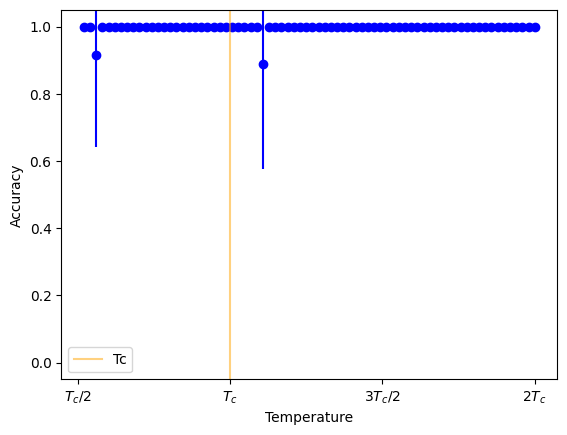

In [63]:
fig = plt.figure()
bins0, vals0, _,_ = binTemps(75, temps, accuracyNPCA, accuracyNPCA, Tcs)
plt.axvline(1, color = 'orange', label = 'Tc', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)

In [64]:
fig.savefig('704Figures/PCA NN VaryN Accuracy.png', bbox_inches = 'tight')

Text(0, 0.5, 'Second Latent Space Dimension')

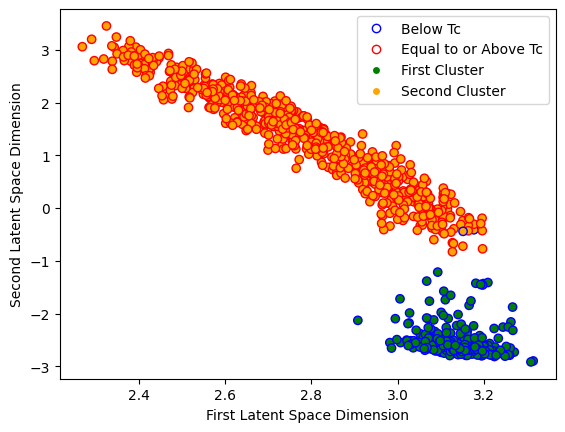

In [65]:
fig = plt.figure()
group1, group2, labels1, labels2 = getGroups(fitImgsVAE, spectralNVAE, temps, Tcs)
plt.scatter(group1[:,0], group1[:,1], color = 'green', label = 'First Cluster', edgecolor = labels1)
plt.scatter(group2[:,0], group2[:,1], color = 'orange', label = 'Second Cluster', edgecolor = labels2)
plt.legend(handles = legend_elements)
# plt.title("VAE with Nearest Neighbors Clustering")
plt.xlabel('First Latent Space Dimension')
plt.ylabel('Second Latent Space Dimension')

In [66]:
fig.savefig('704Figures/VAE VaryingN NN Cluster.png', bbox_inches = 'tight')

1.9999729283102894


([<matplotlib.axis.XTick at 0x7fd964b11c10>,
 [Text(0.5, 0, '$T_c/2$'),
  Text(1.0, 0, '$T_c$'),
  Text(1.5, 0, '$3T_c/2$'),
  Text(2.0, 0, '$2T_c$')])

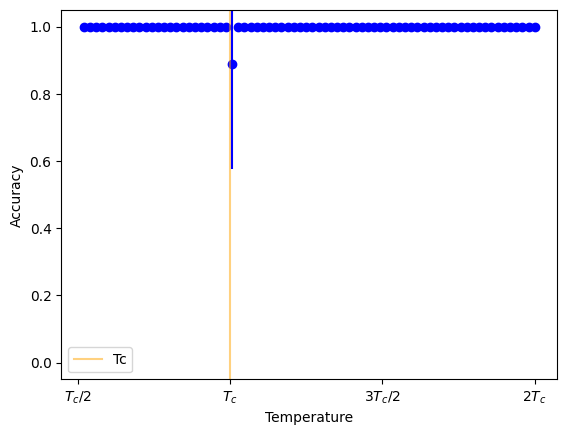

In [67]:
fig = plt.figure()
bins0, vals0, _,_ = binTemps(75, temps, accuracyNVAE, accuracyNVAE, Tcs)
plt.axvline(1, color = 'orange', label = 'Tc', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)

In [68]:
fig.savefig('704Figures/VAE NN VaryN Accuracy.png', bbox_inches = 'tight')

## RBF

Text(0, 0.5, 'Second Principal Component')

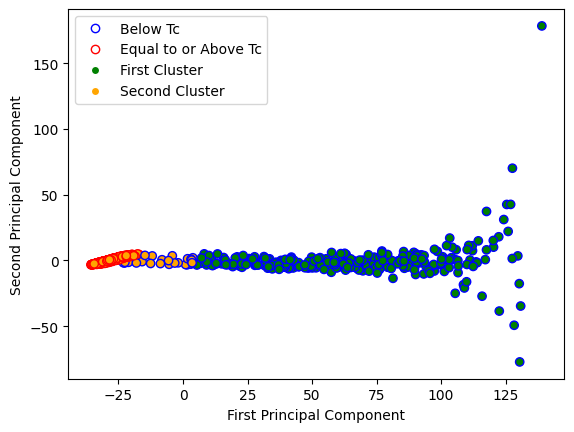

In [69]:
fig = plt.figure()
group1, group2, labels1, labels2 = getGroups(fitImgsPCA, spectralRPCA, temps, Tcs)
plt.scatter(group1[:,0], group1[:,1], color = 'green', label = 'First Cluster', edgecolor = labels1)
plt.scatter(group2[:,0], group2[:,1], color = 'orange', label = 'Second Cluster', edgecolor = labels2)
plt.legend(handles = legend_elements)
# plt.title("PCA with Radial Basis Function Clustering")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [70]:
fig.savefig('704Figures/PCA VaryingN RBF Clustering.png', bbox_inches = 'tight')

1.9999729283102894


([<matplotlib.axis.XTick at 0x7fd964a2cc10>,
 [Text(0.5, 0, '$T_c/2$'),
  Text(1.0, 0, '$T_c$'),
  Text(1.5, 0, '$3T_c/2$'),
  Text(2.0, 0, '$2T_c$')])

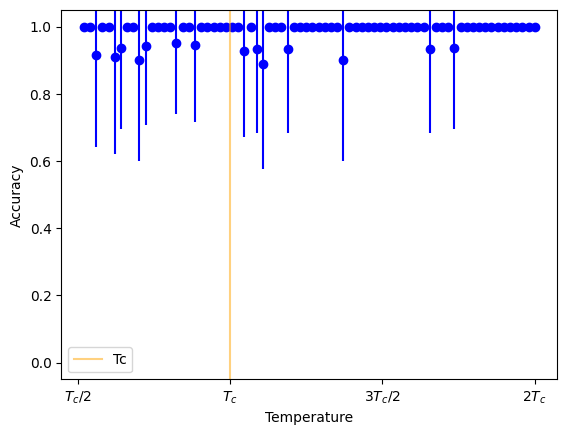

In [71]:
fig = plt.figure()
bins0, vals0, _,_ = binTemps(75, temps, accuracyRPCA, accuracyRPCA, Tcs)
plt.axvline(1, color = 'orange', label = 'Tc', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)

In [72]:
fig.savefig('704Figures/PCA RBF VaryN Accuracy.png', bbox_inches = 'tight')

Text(0, 0.5, 'Second Latent Space Dimension')

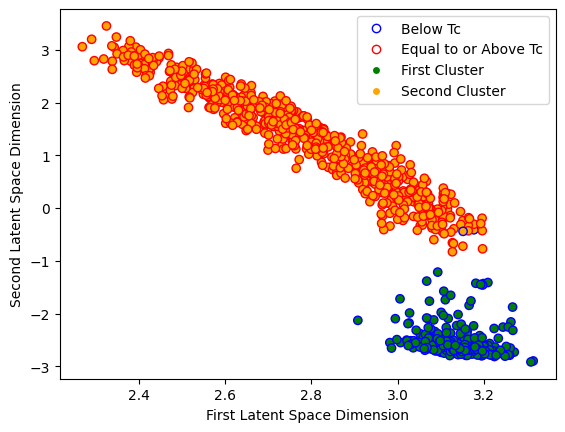

In [73]:
fig = plt.figure()
group1, group2, labels1, labels2 = getGroups(fitImgsVAE, spectralRVAE, temps, Tcs)
plt.scatter(group1[:,0], group1[:,1], color = 'green', label = 'First Cluster', edgecolor = labels1)
plt.scatter(group2[:,0], group2[:,1], color = 'orange', label = 'Second Cluster', edgecolor = labels2)
plt.legend(handles = legend_elements)
# plt.title("VAE with Radial Basis Function Clustering")
plt.xlabel('First Latent Space Dimension')
plt.ylabel('Second Latent Space Dimension')

In [74]:
fig.savefig('704Figures/VAE VaryingN RBF Clustering.png', bbox_inches = 'tight')

1.9999729283102894


([<matplotlib.axis.XTick at 0x7fd9648f9ac0>,
 [Text(0.5, 0, '$T_c/2$'),
  Text(1.0, 0, '$T_c$'),
  Text(1.5, 0, '$3T_c/2$'),
  Text(2.0, 0, '$2T_c$')])

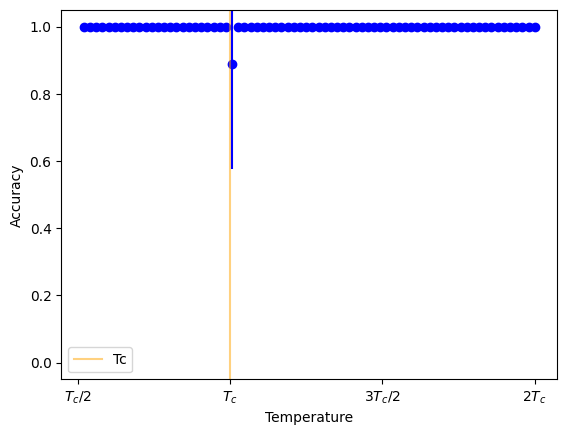

In [75]:
fig = plt.figure()
bins0, vals0, _,_ = binTemps(75, temps, accuracyRVAE, accuracyRVAE, Tcs)
plt.axvline(1, color = 'orange', label = 'Tc', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)

In [76]:
fig.savefig('704Figures/VAE RBF VaryN Accuracy.png', bbox_inches = 'tight')

# Conductance

## Neighbors

1.9999729283102894


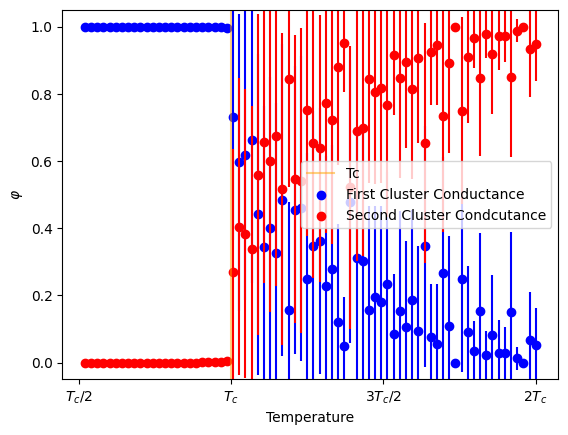

In [77]:
bins0, vals0, bins1, vals1 = binTemps(75, temps, conductanceNPCA0, conductanceNPCA1, Tcs)
fig = plt.figure()
plt.axvline(1, label = 'Tc', color = 'orange', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue', label = 'First Cluster Conductance')
plt.scatter(bins1, vals1[:,0], color = 'red', label = 'Second Cluster Condcutance')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.errorbar(bins1, vals1[:,0], color = 'red', yerr = vals1[:,1], fmt = 'none')
plt.ylim(-0.05, 1.05)
plt.xlabel('Temperature')
plt.ylabel('$\\varphi$')
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)
plt.legend()
# plt.title('PCA Conductance with Nearest Neighbors Clustering')

In [78]:
fig.savefig('704Figures/PCA VaryingN NN Conductance.png', bbox_inches = 'tight')

1.9999729283102894


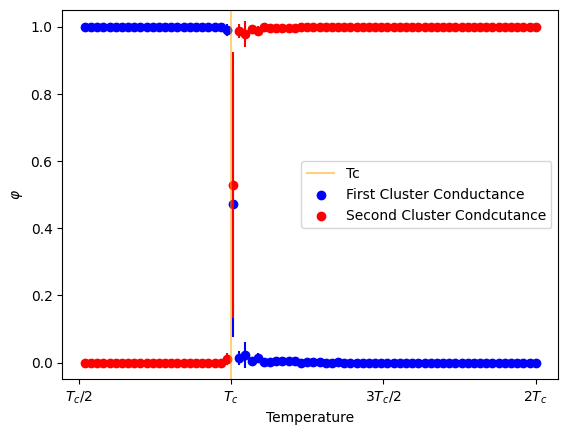

In [79]:
bins0, vals0, bins1, vals1 = binTemps(75, temps, conductanceNVAE0, conductanceNVAE1, Tcs)
fig = plt.figure()
plt.axvline(1, label = 'Tc', color = 'orange', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue', label = 'First Cluster Conductance')
plt.scatter(bins1, vals1[:,0], color = 'red', label = 'Second Cluster Condcutance')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.errorbar(bins1, vals1[:,0], color = 'red', yerr = vals1[:,1], fmt = 'none')
plt.ylim(-0.05, 1.05)
plt.xlabel('Temperature')
plt.ylabel('$\\varphi$')
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)
plt.legend()
# plt.title('VAE Conductance with Nearest Neighbors Clustering')

In [80]:
fig.savefig('704Figures/VAE VaryingN NN Conductance.png', bbox_inches = 'tight')

## RBF

1.9999729283102894


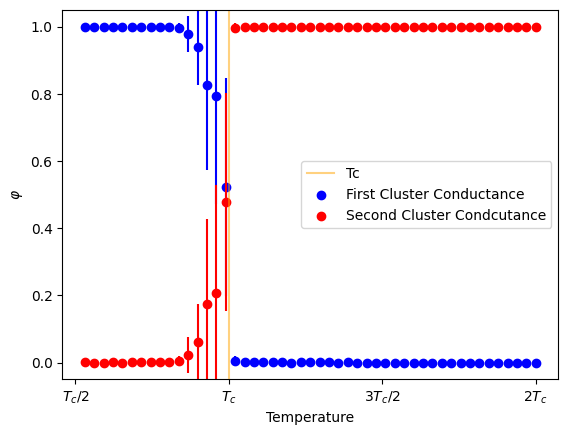

In [81]:
bins0, vals0, bins1, vals1 = binTemps(50, temps, conductanceRPCA0, conductanceRPCA1, Tcs)
fig = plt.figure()
plt.axvline(1, label = 'Tc', color = 'orange', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue', label = 'First Cluster Conductance')
plt.scatter(bins1, vals1[:,0], color = 'red', label = 'Second Cluster Condcutance')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.errorbar(bins1, vals1[:,0], color = 'red', yerr = vals1[:,1], fmt = 'none')
plt.ylim(-0.05, 1.05)
plt.xlabel('Temperature')
plt.ylabel('$\\varphi$')
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)
plt.legend()
# plt.title('PCA Conductance with Radial Basis Function Clustering')

In [82]:
fig.savefig('704Figures/PCA VaryingN RBF Conductance.png', bbox_inches = 'tight')

[]

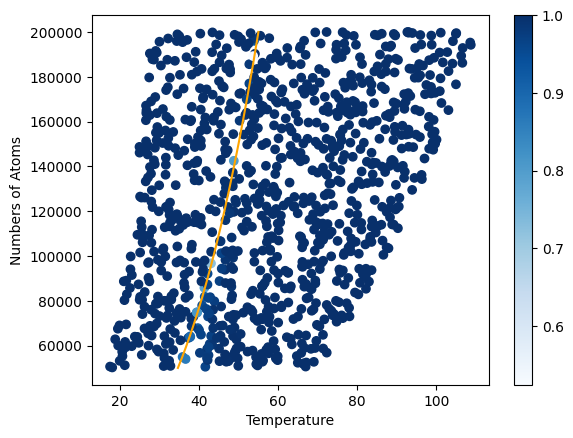

In [83]:
def findTc(x):
    return (x * 2) ** (1 / 3) / (2 * 1.202) ** (1 / 3)
plotNs = np.linspace(50000, 200000, 1000)
plotTcs = findTc(plotNs)
conduct = []
for i in range(len(conductanceNVAE0)):
    conduct.append(max(conductanceNVAE0[i], conductanceNVAE1[i]))
fig = plt.figure()
plt.scatter(temps, Ns, c = conduct, cmap = 'Blues')
plt.plot(plotTcs, plotNs, color = 'orange')
plt.colorbar()
plt.xlabel('Temperature')
plt.ylabel('Numbers of Atoms')

plt.plot()

1.9999729283102894


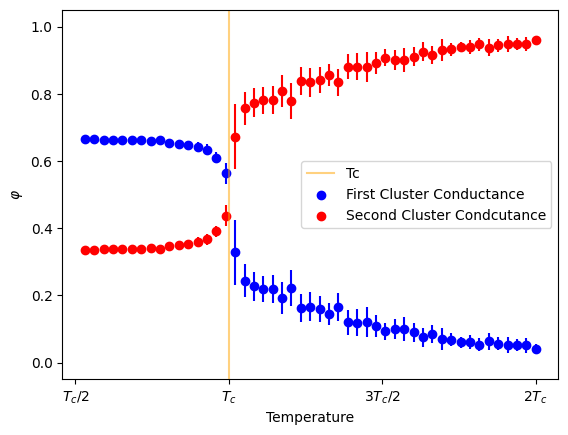

In [84]:
bins0, vals0, bins1, vals1 = binTemps(50, temps, conductanceRVAE0, conductanceRVAE1, Tcs)
fig = plt.figure()
plt.axvline(1, label = 'Tc', color = 'orange', alpha = 0.5)
plt.scatter(bins0, vals0[:,0], color = 'blue', label = 'First Cluster Conductance')
plt.scatter(bins1, vals1[:,0], color = 'red', label = 'Second Cluster Condcutance')
plt.errorbar(bins0, vals0[:,0], color = 'blue', yerr = vals0[:,1], fmt = 'none')
plt.errorbar(bins1, vals1[:,0], color = 'red', yerr = vals1[:,1], fmt = 'none')
plt.ylim(-0.05, 1.05)
plt.xlabel('Temperature')
plt.ylabel('$\\varphi$')
new_xticks = ['$T_c/2$', '$T_c$', '$3T_c/2$', '$2T_c$']
plt.xticks(ticks = [i*1/2 for i in range(1,5)], labels = new_xticks)
plt.legend()
# plt.title('VAE Conductance with Radial Basis Function Clustering')

In [85]:
fig.savefig('704Figures/VAE VaryingN RBF Conductance.png', bbox_inches = 'tight')

# Reconstructions

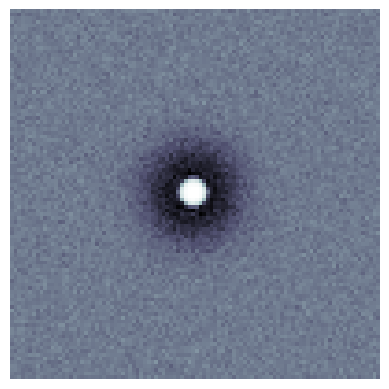

In [86]:
reconstruct = pca.components_
component1 = reconstruct[0].reshape(y,y)
component2 = reconstruct[1].reshape(y,y)
fig = plt.figure()
plt.axis('off')
plt.imshow(component1, cmap = 'bone')
# plt.title('First Principal Component')

In [87]:
fig.savefig('704Figures/PCAReconstructionN1.png', bbox_inches = 'tight')

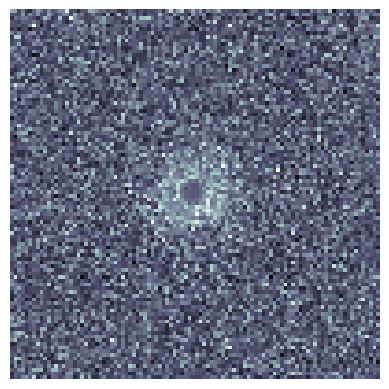

In [88]:
fig = plt.figure()
plt.axis('off')
plt.imshow(component2, cmap = 'bone')
# plt.title('Second Principal Component')

In [89]:
fig.savefig('704Figures/PCAReconstructionN2.png', bbox_inches = 'tight')

[3.1373534, -2.5347793] [2.7808678, 1.306447]


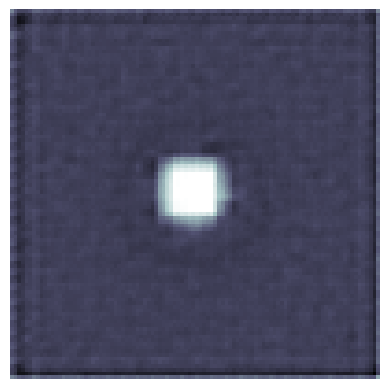

In [90]:
group1 = fitImgsVAE[temps < Tcs]
group2 = fitImgsVAE[temps >= Tcs]
lowTempLatent = [np.mean(group1[:,0]),np.mean(group1[:,1])]
highTempLatent = [np.mean(group2[:,0]),np.mean(group2[:,1])]
print(lowTempLatent, highTempLatent)
latent = vae.decode(tf.convert_to_tensor([lowTempLatent,highTempLatent]))
fig = plt.figure()
plt.axis('off')
plt.imshow(latent[0], cmap = 'bone')
# plt.title('First Cluster Decoding')

In [91]:
fig.savefig('704Figures/VAEReconstructionN1.png', bbox_inches = 'tight')

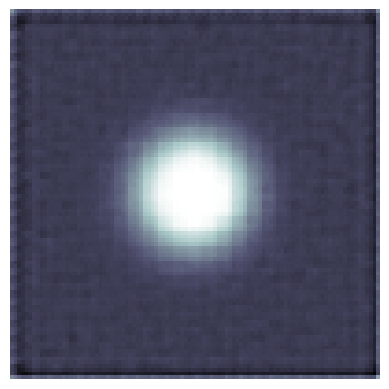

In [92]:
fig = plt.figure()
plt.axis('off')
plt.imshow(latent[1], cmap = 'bone')
# plt.title('Second Cluster Decoding')

In [93]:
fig.savefig('704Figures/VAEReconstructionN2.png', bbox_inches = 'tight')